In [7]:
# Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored

%matplotlib inline

In [8]:
# Import
df = pd.read_csv("2016.12.16.csv")
pd.set_option('display.max_rows', df.shape[0]+1)

In [9]:
# Functions

def add_bet_risk_and_bet_profit_colummns_to_df(df):
    
    # risk
    df['BetRisk'] = df.Odds * df.Stake - df.Stake
    back_bets_indeces = df[df.BidType == "Back"].index.tolist()
    for back_bet_index in back_bets_indeces:
        df.set_value(back_bet_index, 'BetRisk', df.Stake[back_bet_index])
        
    # profit
    df['BetProfit'] = df.Odds * df.Stake - df.Stake
    lay_bets_indeces = df[df.BidType == "Lay"].index.tolist()
    for lay_bet_index in lay_bets_indeces:
        df.set_value(lay_bet_index, 'BetProfit', df.Stake[lay_bet_index])
    return df

def add_profit_trade_and_loss_trade_columns(df):
    df['LossTrade'] = (-1) * df['ProfitLoss'][df['ProfitLoss'] < 0]
    df['ProfitTrade'] = df['ProfitLoss'][df['ProfitLoss'] > 0]
    return df

def get_outliers(df, column):
    outliers = []
    summary = df.describe().round(2)
    q1 = summary[column]['25%']
    q2 = summary[column]['50%']
    q3 = summary[column]['75%']
    return list(df[column][df[column] > q2 + 1.5*(q3-q1)])

def show_comparision_two_features(df, first, second, first_legend, second_legend, title):   
    # bet's potential losses and profits
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (16,5))

    # distribution of bet's potential losses and profits
    sns.distplot(df[first], bins = 100, kde = True, hist = False, color = 'b', 
                 ax = ax1, label = '')
    sns.distplot(df[second], bins = 100, kde = True, hist = False, color = 'g', 
                 ax = ax1, label = '')

    # boxplot for bet's potential loss and profit
    bidtype_betrisk_betprofit = df.ix[:, [first, second]]
    sns.boxplot(data = bidtype_betrisk_betprofit, showfliers = False, ax = ax2)

    # stripplot for bet's potential loss and profit outliers
    outliers = {second: get_outliers(df, second),
               first: get_outliers(df, first)}

    sp = pd.DataFrame.from_dict(outliers, orient = 'index').T
    sp = sp[[first, second]]
    sns.stripplot(data=sp, ax = ax3)

    # legend and axes labels
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Density')
    ax1.legend([first_legend, second_legend], fontsize = 12)
    ax1.set_xlim([0, max([summary.ix['max', first], summary.ix['max', second]])])
    ax1.set_title('Distribution', fontsize = 14)
    ax2.set_ylabel('Value')
    ax2.set_title('Boxplot (no outliers)', fontsize = 14)
    ax3.set_ylabel('Value')
    ax3.set_title('Outliers', fontsize = 14)

    fig.suptitle(title, fontsize = 20).set_position([0.5, 1.05]);
    
def show_markets(df, title):
    # unique markets
    markets = []
    for market in df.Market:
        markets.append(market.split('/')[-1].strip())
    list_of_markets = list(set(markets))

    #count markets
    market_freq = {}
    for market in list_of_markets:
        market_freq[market] = markets.count(market)

    # figure params    
    fig = plt.figure(figsize = (16,5))  
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)

    # draw pie chart
    freq = market_freq.values()
    labels = market_freq.keys()
    explode = [0.2 for i in range(len(freq))]
    patches, texts, autotexts = ax1.pie(freq, startangle=30, explode = explode, 
                                  autopct = '%.1f%%', pctdistance = 1.2)
    
    for autotext in autotexts:
        autotext.set_fontsize(12)
    
    colors = sns.hls_palette(int(len(patches)*1.3), l=.3, s=.9)
    for patch, color_index in zip(patches, range(len(patches))):
        patch.set_color(colors[color_index])
        
    ax1.axis('equal')
    
    ax2.legend(patches, labels, loc = 3, fontsize = 14)
    ax2.axis('off')
    
    fig.suptitle(title, fontsize = 20).set_position([0.5, 1.05])
    
    plt.show()
    
def find_most_consec_losses_and_wins(df):
    most_consec_wins = 0
    most_consec_losses = 0
    count_losses = 0
    count_wins = 0

    for each in list(df.ProfitLoss):

        # count losers
        if each < 0:
            count_losses +=1
        else:
            count_losses = 0
        if count_losses > most_consec_losses:
            most_consec_losses = count_losses

        # count winners
        if each > 0:
            count_wins +=1
        else:
            count_wins = 0
        if count_wins > most_consec_wins:
            most_consec_wins = count_wins
    return most_consec_losses, most_consec_wins

In [10]:
# Dataset 
df = add_bet_risk_and_bet_profit_colummns_to_df(df).round(2)
df = add_profit_trade_and_loss_trade_columns(df).round(2)
summary = df.describe().round(2)
summary

,Odds,Stake,ProfitLoss,BetRisk,BetProfit,LossTrade,ProfitTrade
count,303.00,303.00,303.00,303.00,303.00,183.00,120.00
mean,4.55,8.65,0.87,8.03,11.57,5.14,10.04
std,10.36,9.10,10.38,10.87,11.40,6.10,8.72
min,1.01,0.04,-49.54,0.01,0.04,0.01,0.04
25%,1.46,3.00,-3.70,2.00,5.00,1.48,5.00
50%,1.96,6.00,-1.00,4.05,8.94,3.00,8.00
75%,3.40,10.00,6.08,10.00,13.24,7.00,11.55
max,100.00,65.42,50.00,90.00,72.66,49.54,50.00


In [11]:
# KPIs:

# Losers
total_losers = summary.ix['count', 'LossTrade']
gross_loss = round(df['LossTrade'].sum(),2)
avg_loss = round(summary.ix['mean', 'LossTrade'],2)
max_loss = round(summary.ix['max', 'LossTrade'],2)

# Winners
total_winners = summary.ix['count', 'ProfitTrade']
gross_win = round(df['ProfitTrade'].sum(), 2)
avg_win = round(summary.ix['mean', 'ProfitTrade'],2)
max_win = round(summary.ix['max', 'ProfitTrade'],2)

# Losers and Winners
most_consec_losses, most_consec_wins = find_most_consec_losses_and_wins(df)

# Totals
starting_budget = 1000
total_trades = summary.ix['count', 'Stake']
avg_trade = round(summary.ix['mean', 'ProfitLoss'],2)
total_net_profit = round(df.ProfitLoss.sum(),2)
profit_percentage = round(100*total_net_profit/starting_budget,2)
winning_percentage = round(total_winners / total_trades,2)
profit_factor = round(gross_win / gross_loss,2)
payout_ratio = round((avg_win / avg_loss), 2)
expectancy = round(avg_trade / avg_loss, 2)
kelly_pct = round(avg_trade / avg_win, 2)

In [31]:
# Print trading performance report

print colored("Starting budget: ", "red") + "£" + str(starting_budget)

print colored("\nWinning Trades:", "green") + \
    "\nNumber Of Winning Bets: " + str(int(total_winners)) + \
    "\nGross Profit: £" + str(gross_win) + \
    "\nAverage Win: £" + str(avg_win) + \
    "\nLargest Win: £" + str(max_win) + \
    "\nMost Consec Wins: " + str(most_consec_wins)
    
print colored("\nLosing Trades:", "blue") + \
    "\nNumber Of Losing Bets: " + str(int(total_losers)) + \
    "\nGross Loss: £" + str(gross_loss) + \
    "\nAverage Loss: £" + str(avg_loss) + \
    "\nLargest Loss: £" + str(max_loss) + \
    "\nMost Consec Losses: " + str(most_consec_losses)
      
print colored("\nOverall: ", "magenta") + \
    "\nTotal Number Of Bets: " + str(int(total_trades)) + \
    "\nAverage Trade: " + str(avg_trade) + \
    "\nTotal Profit: £" + str(total_net_profit) + \
    "\nTotal Profit: " + str(profit_percentage) + "%" + \
    "\nWinning Percentage: " + str(100*winning_percentage) + "%" + \
    "\nProfit Factor: " + str(profit_factor) + \
    "\nPayout Ratio: " + str(payout_ratio) + \
    "\nExpectancy: " + str(expectancy) + \
    "\nKelly Pct: " + str(kelly_pct)

Starting budget: £1000

Winning Trades:
Number Of Winning Bets: 120
Gross Profit: £1205.4
Average Win: £10.04
Largest Win: £50.0
Most Consec Wins: 8

Losing Trades:
Number Of Losing Bets: 183
Gross Loss: £940.83
Average Loss: £5.14
Largest Loss: £49.54
Most Consec Losses: 9

Overall: 
Total Number Of Bets: 303
Average Trade: 0.87
Total Profit: £264.57
Total Profit: 26.46%
Winning Percentage: 40.0%
Profit Factor: 1.28
Payout Ratio: 1.95
Expectancy: 0.17
Kelly Pct: 0.09


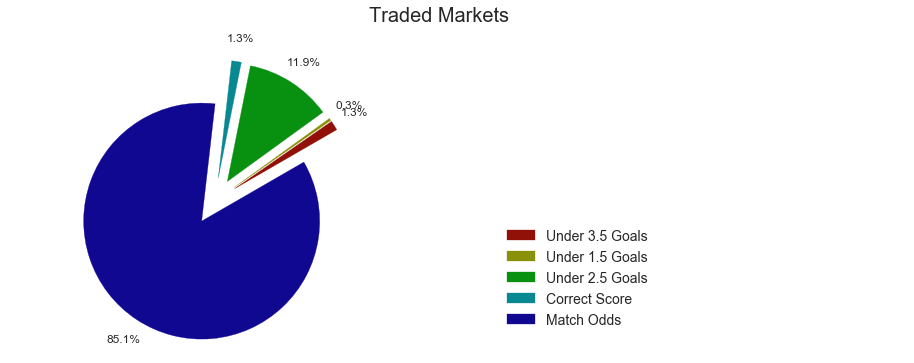

In [547]:
show_markets(df, 'Traded Markets')

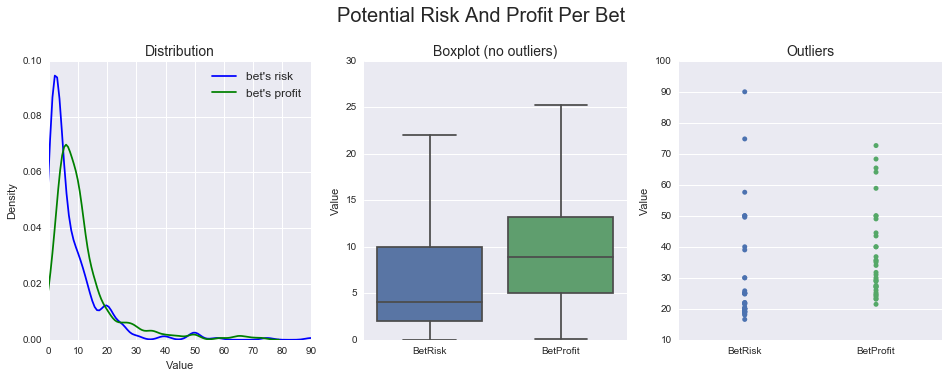

In [548]:
show_comparision_two_features(df, 'BetRisk', 'BetProfit', 'bet\'s risk', 'bet\'s profit', 'Potential Risk And Profit Per Bet')

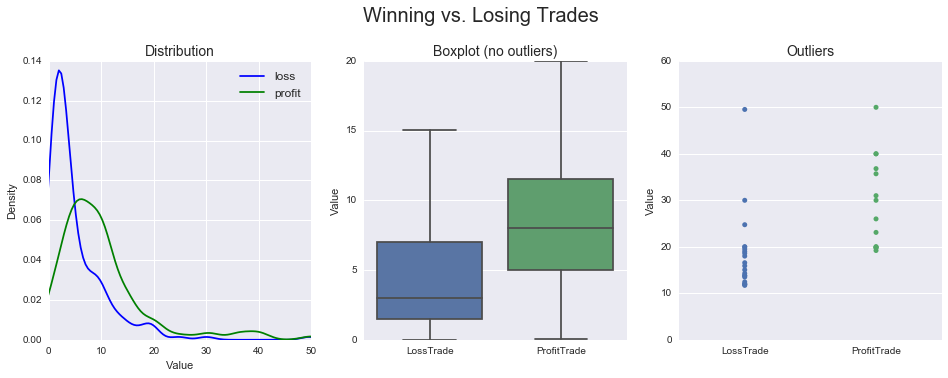

In [549]:
show_comparision_two_features(df, 'LossTrade', 'ProfitTrade',
                              'loss', 'profit', 'Winning vs. Losing Trades')

In [313]:
# Dataset
df

,Market,Selection,BidType,Odds,Stake,ProfitLoss,BetRisk,BetProfit,LossTrade,ProfitTrade
0,16 December / Hoffenheim v Dortmund / Match Odds,The Draw,Lay,1.33,3.00,-0.99,0.99,3.00,0.99,NaN
1,16 December / Alaves v Betis / Match Odds,Alaves,Lay,1.29,10.00,-2.90,2.90,10.00,2.90,NaN
2,16 December / Norwich v Huddersfield / Match ...,Huddersfield,Lay,1.53,2.00,-1.06,1.06,2.00,1.06,NaN
3,16 December / Hoffenheim v Dortmund / Match Odds,Hoffenheim,Back,2.60,2.00,-2.00,2.00,3.20,2.00,NaN
4,16 December / Angers v Nantes / Match Odds,Nantes,Lay,1.63,5.00,-3.15,3.15,5.00,3.15,NaN
5,16 December / Norwich v Huddersfield / Match ...,Huddersfield,Lay,1.78,5.00,-3.90,3.90,5.00,3.90,NaN
6,16 December / Hoffenheim v Dortmund / Match Odds,Hoffenheim,Back,1.45,8.12,-8.12,8.12,3.65,8.12,NaN
7,16 December / Hoffenheim v Dortmund / Match Odds,Hoffenheim,Lay,2.34,5.00,5.00,6.70,5.00,NaN,5.00
8,12 December / Roma v AC Milan / Match Odds,Roma,Lay,1.27,4.00,-1.08,1.08,4.00,1.08,NaN
9,12 December / Villarreal v Atletico Madrid / ...,Villarreal,Lay,1.28,4.00,-1.12,1.12,4.00,1.12,NaN
